In [1]:
import sys, os, glob
sys.path.append('../')

import tensorflow as tf
import numpy as np


from MRIsegm.utils import get_slices, get_rois, explore_slices, mask_slices, display_images
from MRIsegm.metrics import dice_coef
from MRIsegm.losses import DiceBCEloss
from MRIsegm.processing import pre_processing_data, predict_images

from segmentation_models.losses import DiceLoss, BinaryFocalLoss



Segmentation Models: using `keras` framework.


In [2]:
models_dir = '../data/models'
model_path = glob.glob(models_dir + '/*full_2*.h5')

dice_loss = DiceLoss()
focal_loss = BinaryFocalLoss()
loss = dice_loss + (1 * focal_loss)

dependencies = {
    'DiceBCEloss': DiceBCEloss,
    'dice_coef': dice_coef,
    'FixedDropout': tf.keras.layers.Dropout(0.1),
    'dice_loss_plus_1binary_focal_loss': loss
}

print(model_path[0])
model = tf.keras.models.load_model(model_path[0], custom_objects=dependencies)



../data/models/efficientnetb0_BTC=4_full_2_OPT=adam_LOSS=DiceBCEloss.h5


In [3]:
src = '/Users/giuseppefilitto/Pazienti_anonym_sorted/'
patient = 'BO85/'
dir_path =  src + patient + 'T2'

slices = get_slices(dir_path=dir_path) 

In [4]:
preprocessed = pre_processing_data(slices)

In [5]:
preprocessed.shape

(26, 512, 512, 1)

In [6]:
from MRIsegm.processing import crop_image
import numpy as np

cropped_s = np.zeros(shape=(preprocessed.shape[0], 256,256))
for i in range(preprocessed.shape[0]):
    img_s = np.squeeze(preprocessed[i, ...])
    cropped = crop_image(img_s)
    cropped_s[i, ...]= cropped


In [7]:
cropped_s = np.expand_dims(cropped_s, axis=-1)

In [8]:
cropped_s.shape

(26, 256, 256, 1)

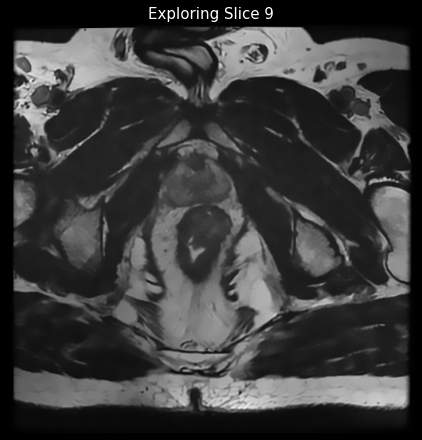

In [9]:
layer = 9
#explore_slices(slices=cropped_s, layer=layer)
explore_slices(slices=preprocessed, layer=layer)

In [10]:
#predicted = predict_images(cropped_s, model)
predicted = predict_images(preprocessed, model)

In [11]:
predicted.shape

(26, 512, 512, 1)

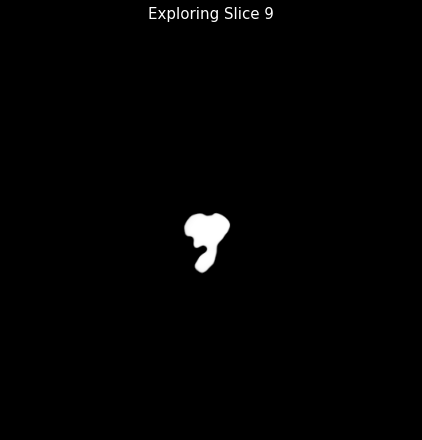

In [12]:
explore_slices(slices=predicted, layer=layer)

In [13]:
roi_path = src + patient + 'T2ROI'

rois = get_rois(roi_path=roi_path) 
positions = [rois[i].get('position') - 1 for i in range(len(rois))]

# set(positions) to have unique values
print(f"number of masks = {len(set(positions))}")

number of masks = 15


In [14]:
slices_of_masks = mask_slices(slices=slices, rois=rois)

In [15]:
from MRIsegm.processing import crop_masks

cropped_m = crop_masks(slices_of_masks)

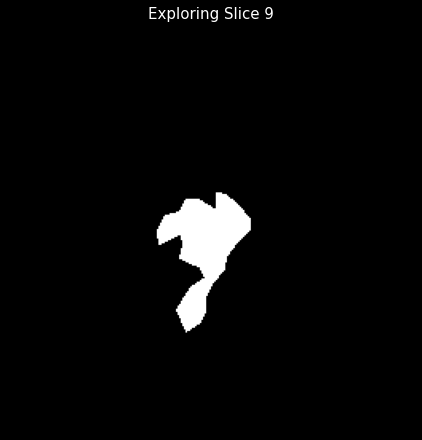

In [16]:
explore_slices(slices=cropped_m, layer=layer)

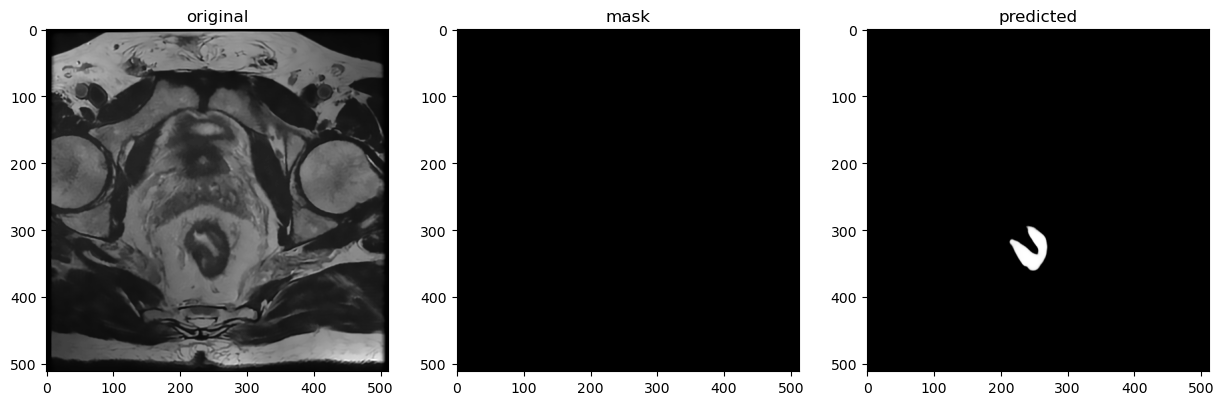

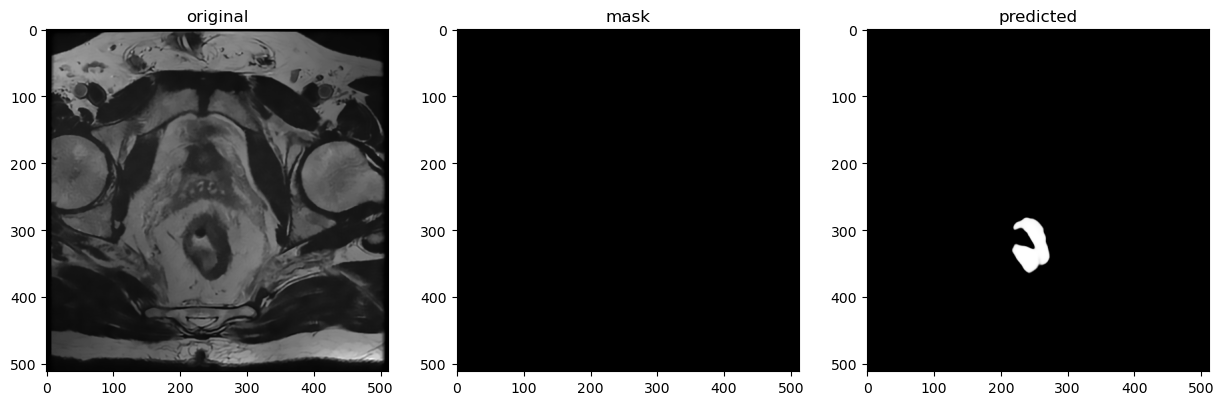

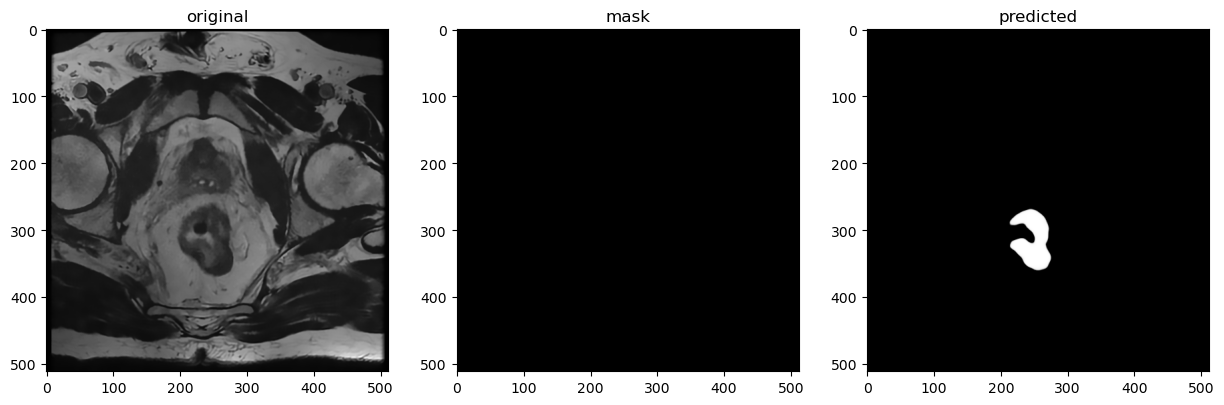

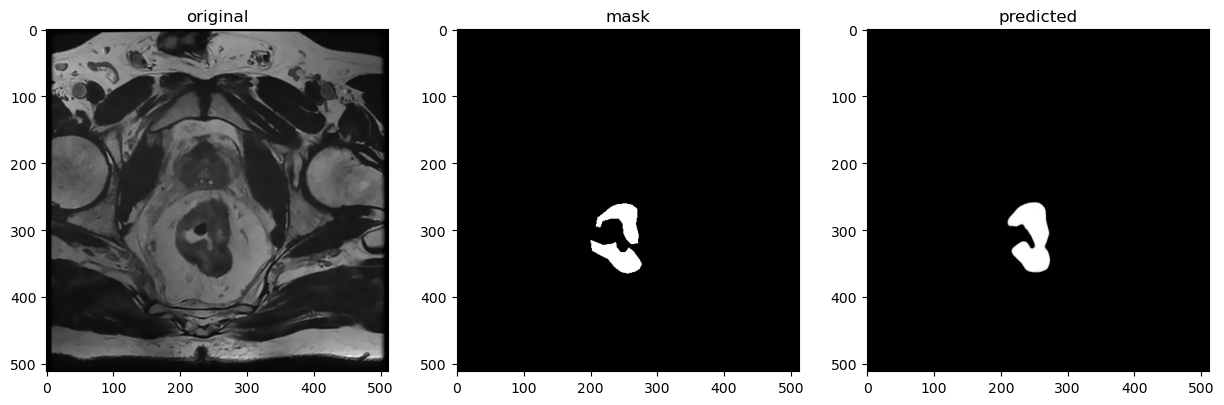

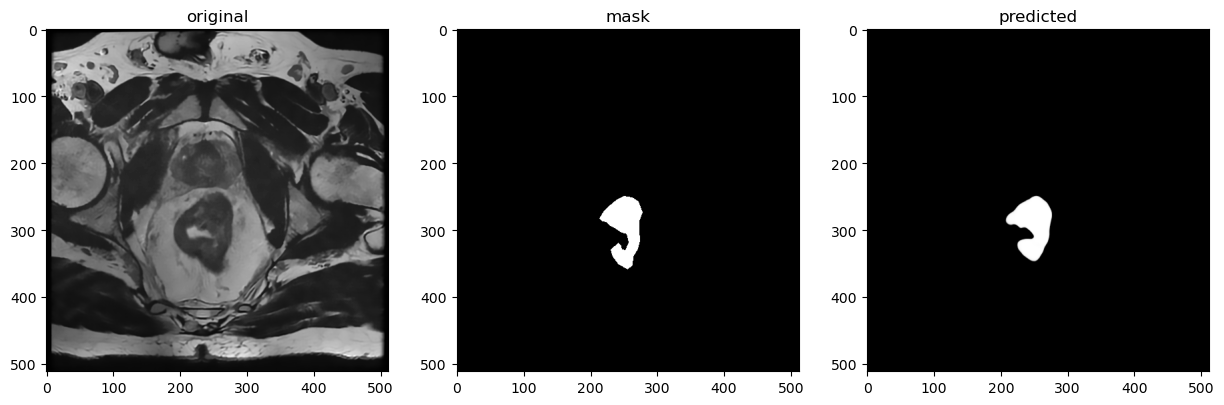

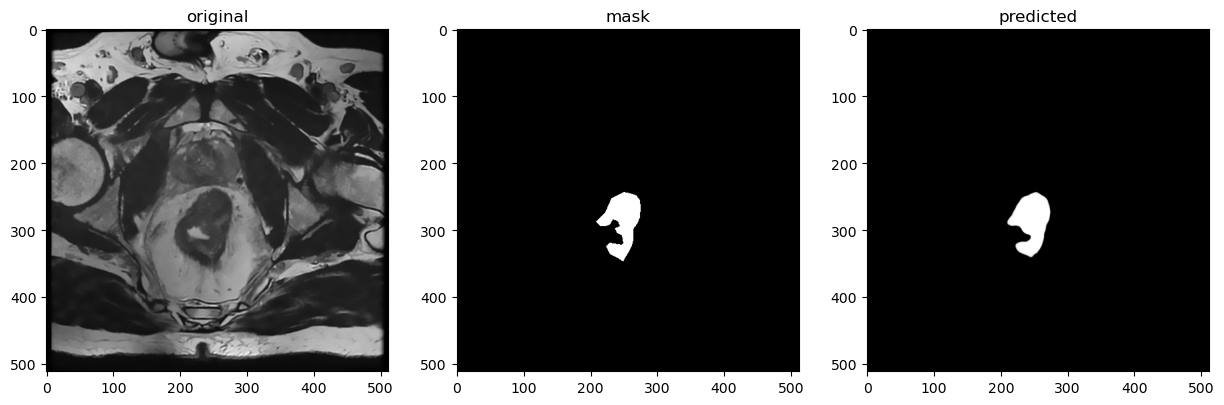

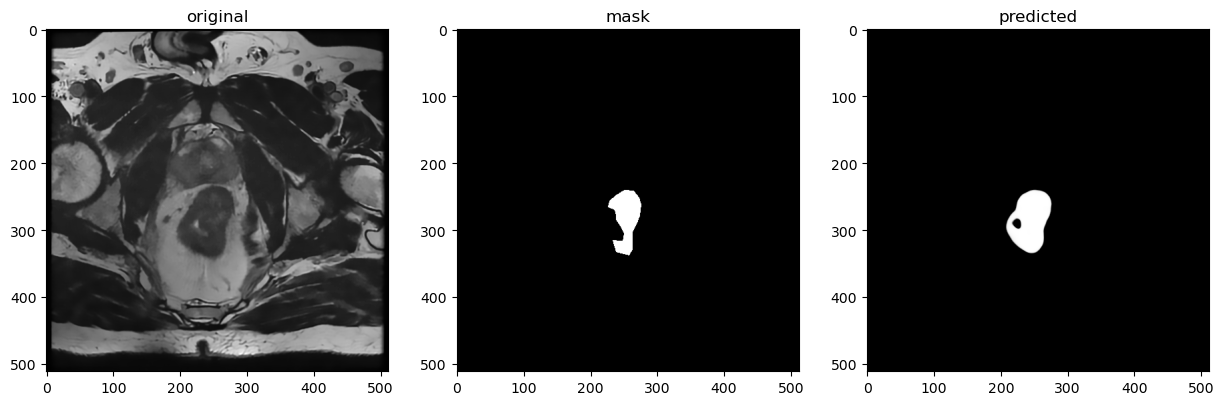

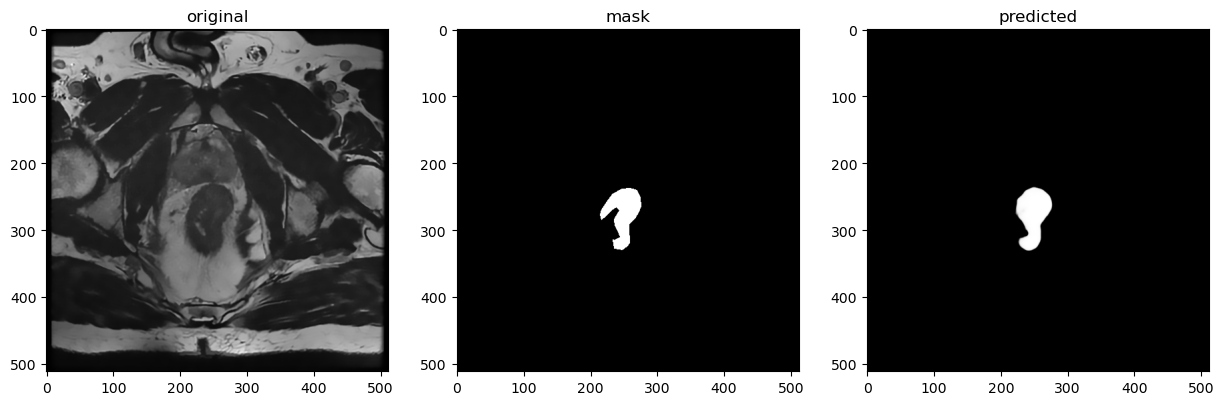

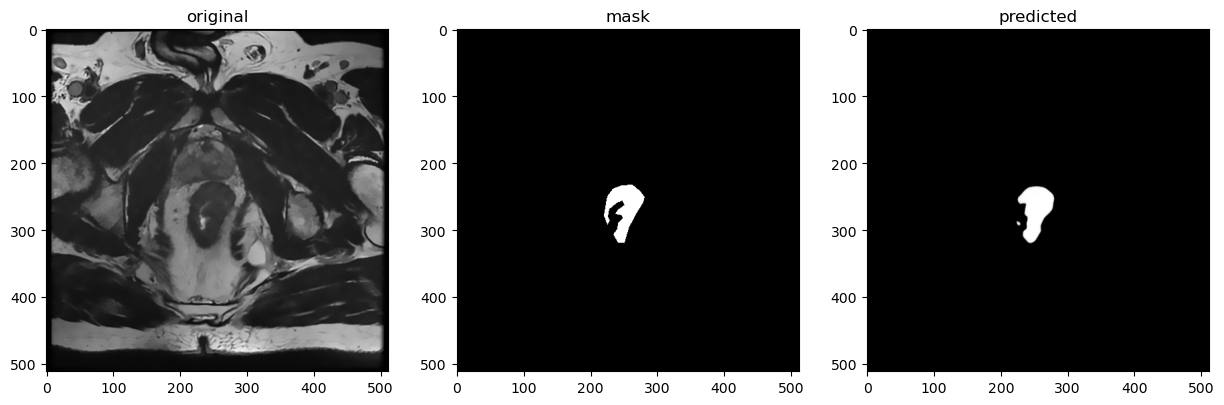

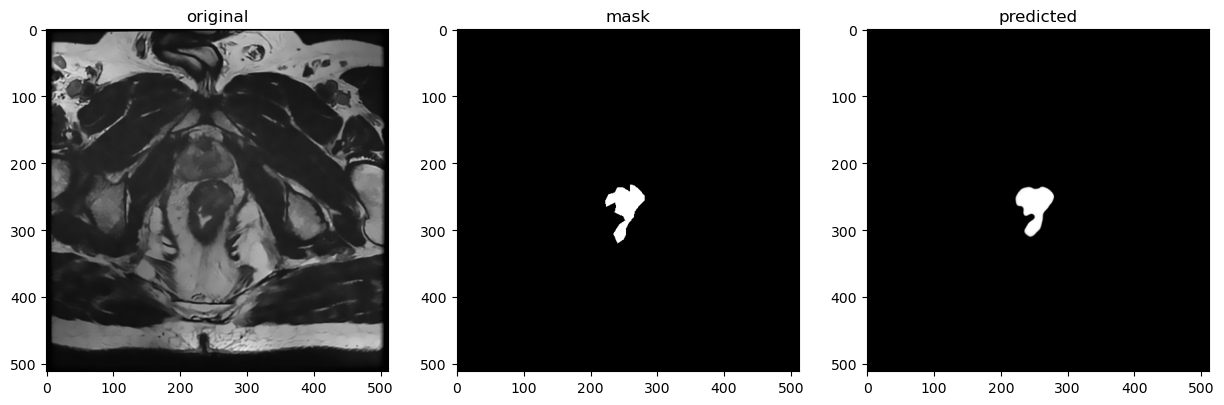

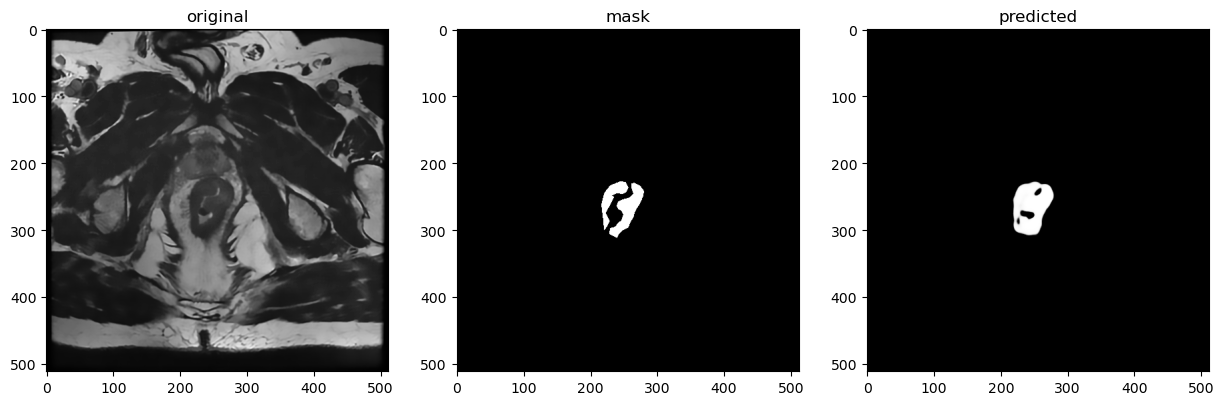

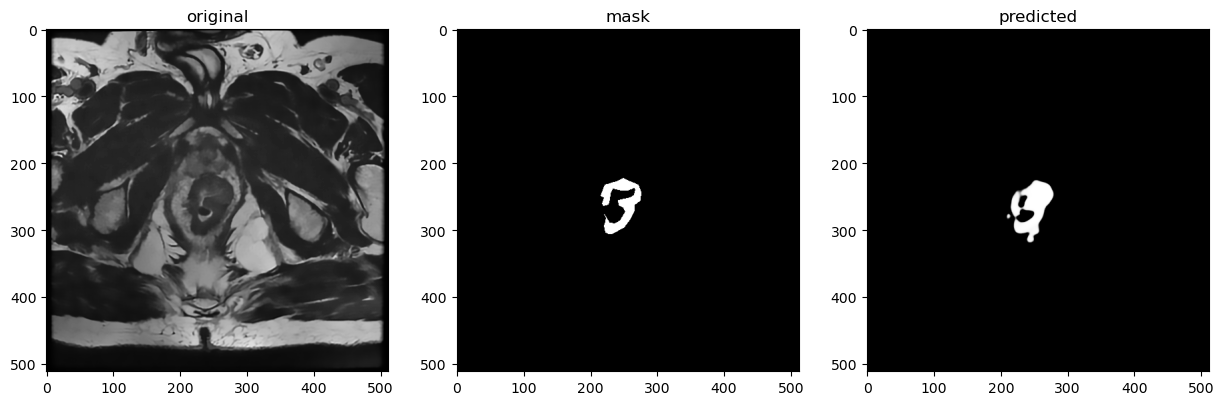

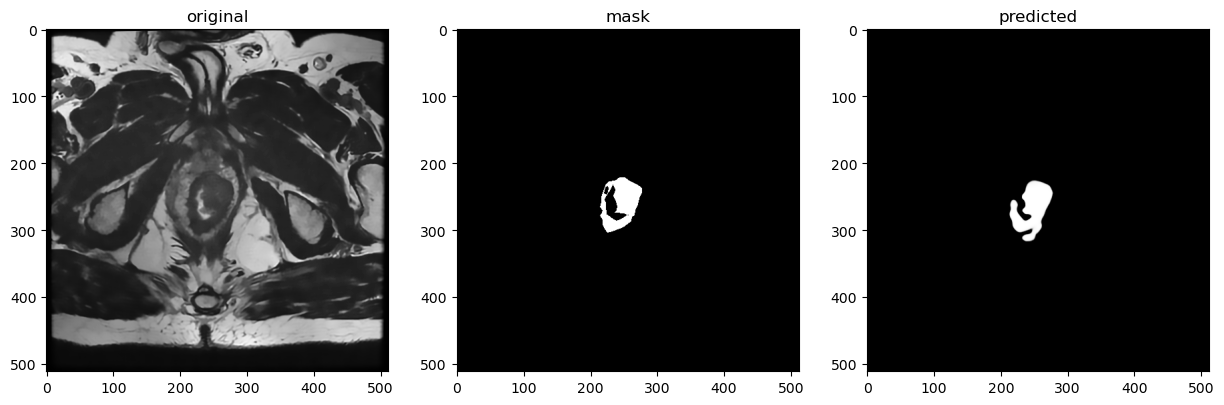

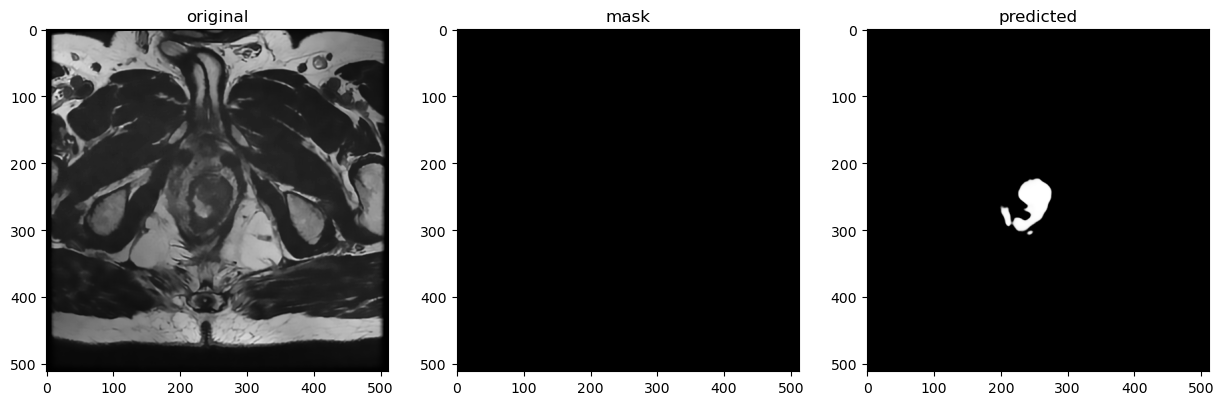

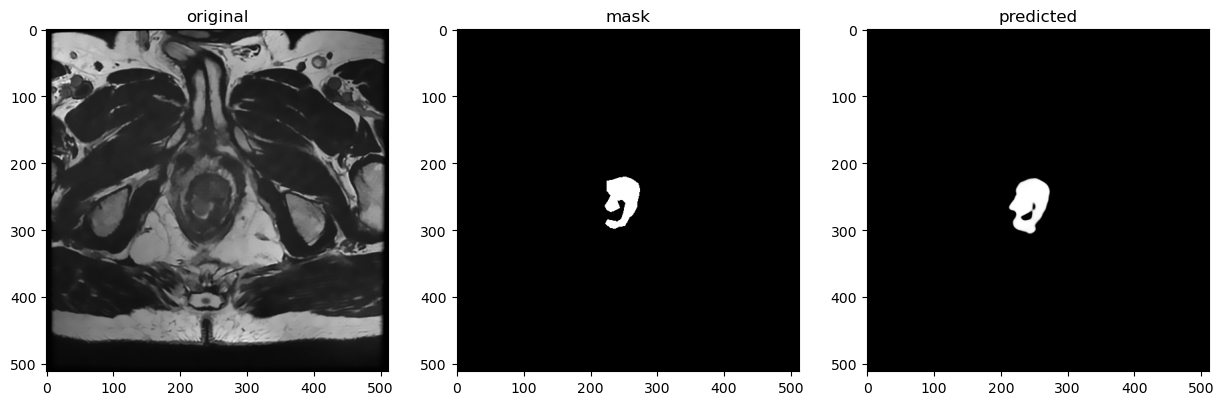

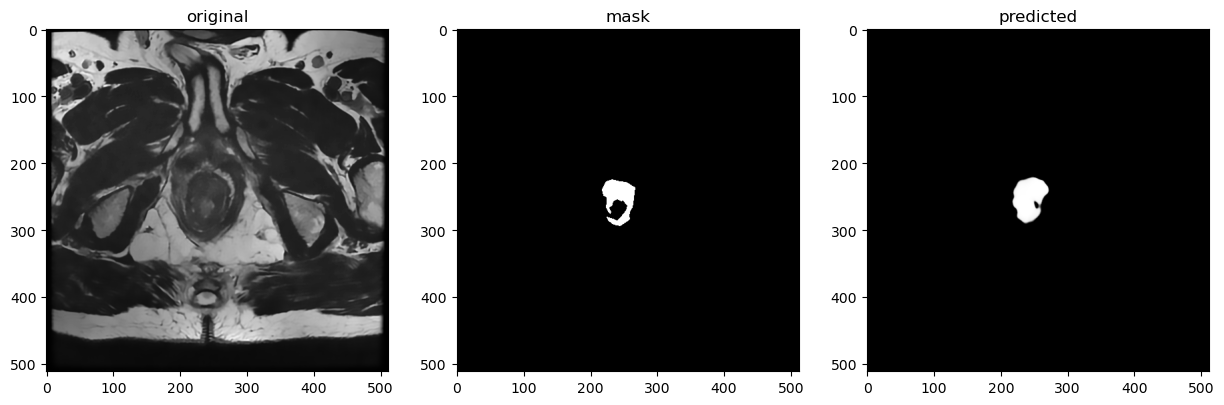

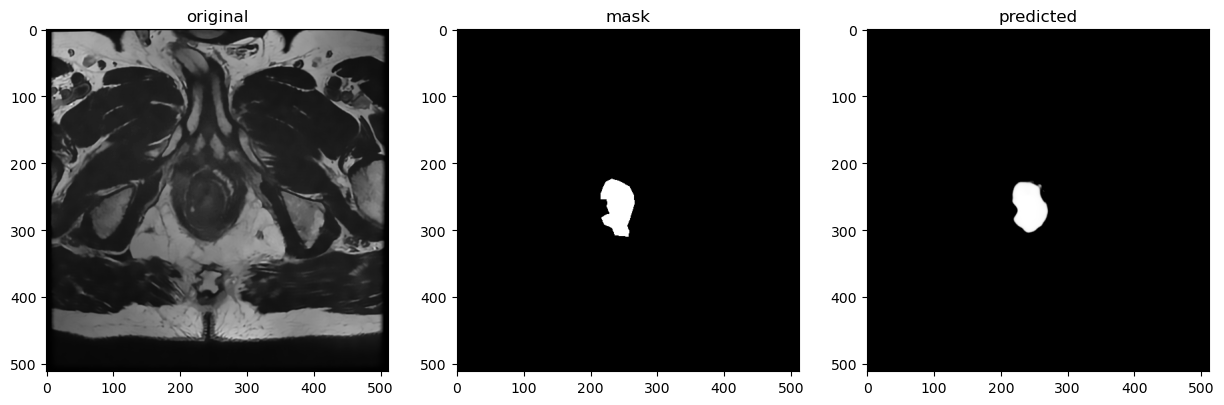

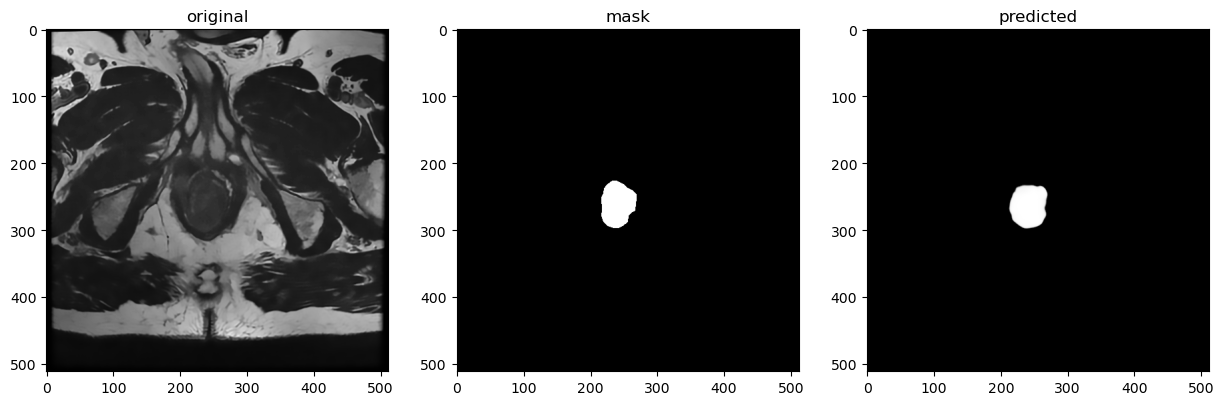

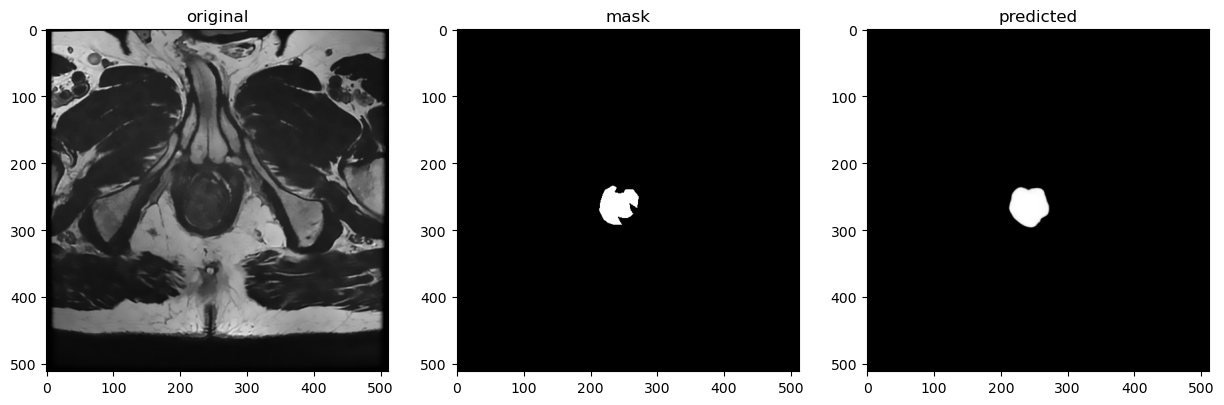

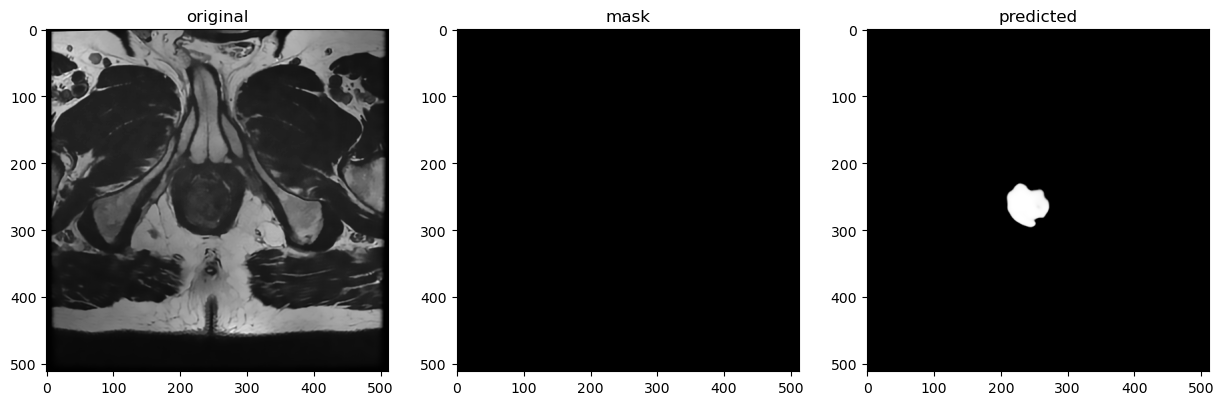

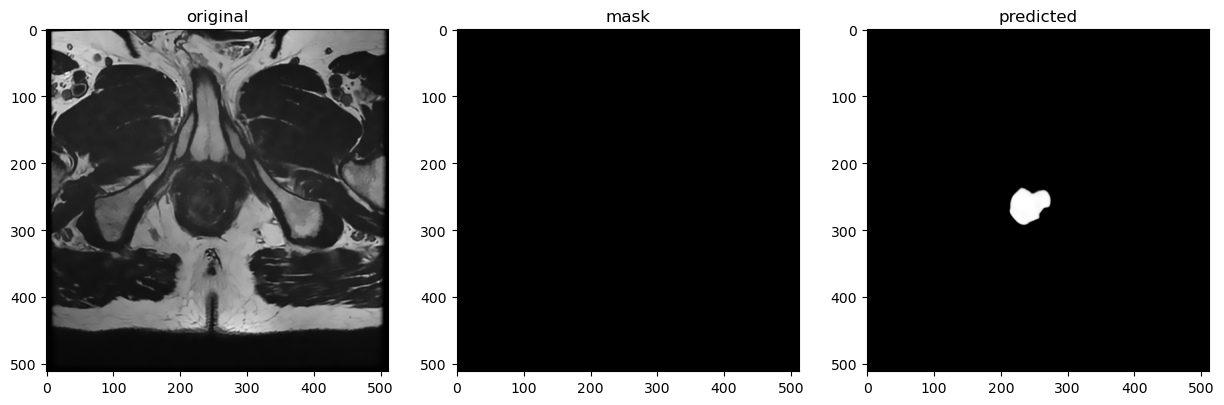

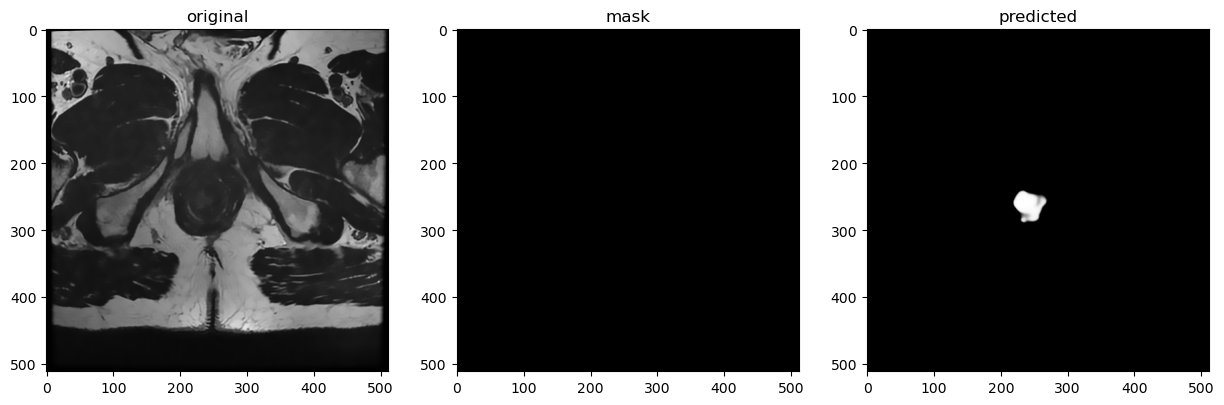

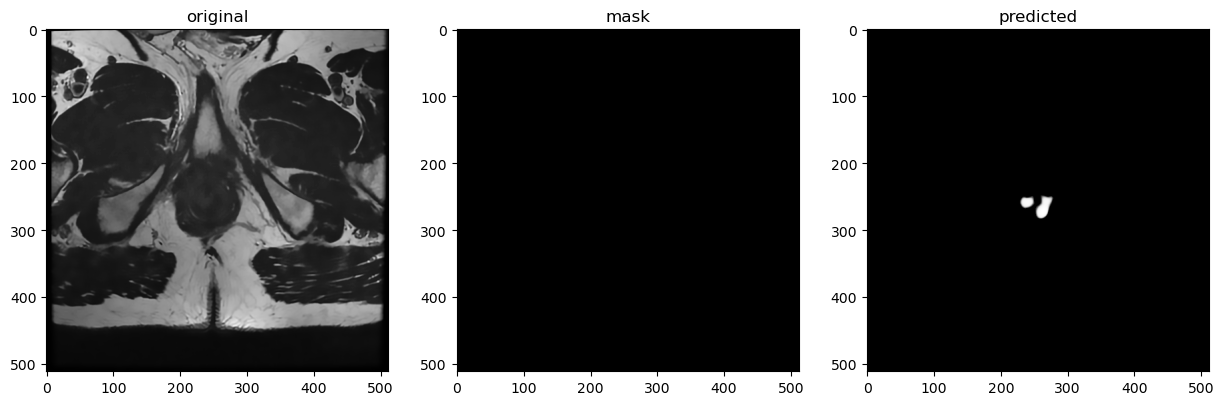

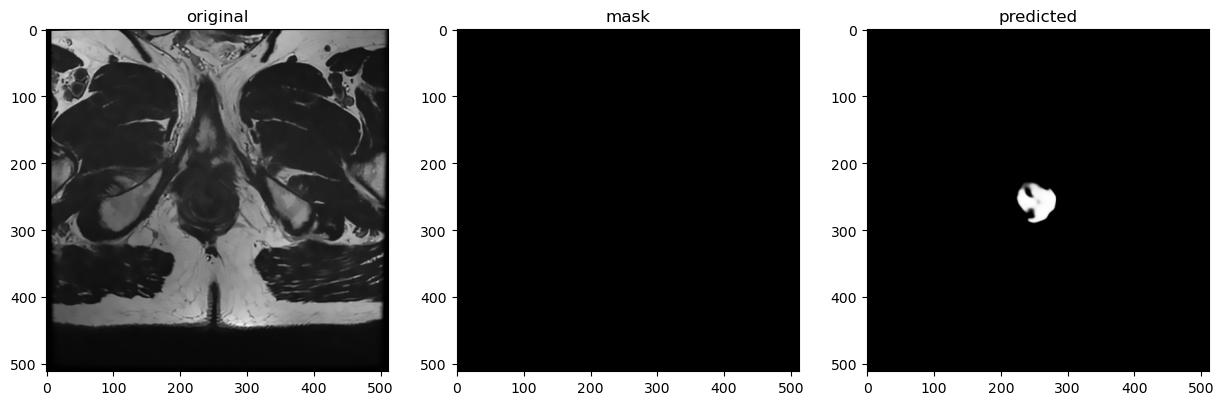

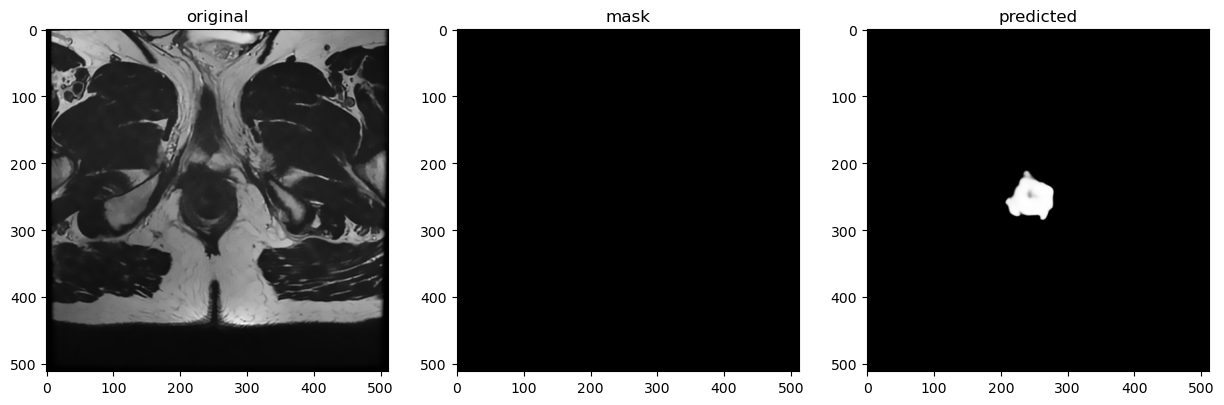

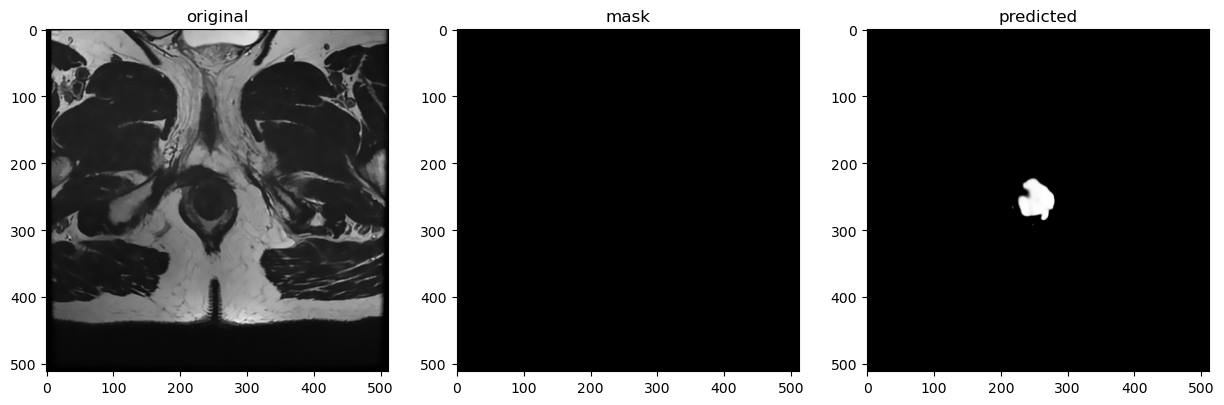

In [17]:
import matplotlib.pyplot as plt
plt.style.use('default')

for i in range(slices.shape[0]):
    original = preprocessed[i, ...]
    mask = slices_of_masks[i, ...]
    pred = np.where(predicted[i, ...] <= 0.01, 0, predicted[i, ...])
    display_images([original, mask, pred],figsize=(15,5), titles=['original', 'mask', 'predicted'])